In [1]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse

In [2]:
ab = pd.read_csv('../data/habsos_20230714.csv', parse_dates=['SAMPLE_DATE'])
ab = ab.sort_values(by=['SAMPLE_DATE'])
ab = ab.dropna(subset=['SALINITY','WATER_TEMP'], how='any')
abfl = ab.loc[ab.STATE_ID=='FL'].copy()

C:\Users\Peter Doze\AppData\Local\Temp\ipykernel_3032\3733098441.py:1: DtypeWarning: Columns (18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  ab = pd.read_csv('../data/habsos_20230714.csv', parse_dates=['SAMPLE_DATE'])


In [3]:
#abfl = abfl.loc[abfl.CATEGORY != 'not observed'] in my field we don't get rid of zeros they help tell you about the trend

## Prevoius EDA showed that most of the data is from Florida. So we train on Florida and try to predict the others. Previous EDA showed that the data is stationary so we can skip that step

### Recasting the data as Mean Cellcount by Month: a means of trying to standardize the data since the time intervals are irregular. We won't be able to forecast a particular month of algae blooms because the data has no seasonality but we might be able to forecast a month average.

In [4]:
abflgroup = abfl.groupby([abfl.SAMPLE_DATE.dt.year, abfl.SAMPLE_DATE.dt.month])\
    [['CELLCOUNT','SALINITY','WATER_TEMP']].mean()


In [5]:
idx = [datetime(i[0],i[1],1) for i in abflgroup.index]

In [6]:
ab2 = abflgroup.copy()
ab2.index = idx

### Recasting the datat as Rolling Average by 30 days: a means of preparing the raw data by smoothing it and removing (some) noise, and better expose the structure of the processes.

In [7]:
delta = timedelta(days=30)


In [8]:
ab3 = abfl.copy()
ab3.set_index('SAMPLE_DATE', inplace=True)
ab3['roll_avg'] = ab3.CELLCOUNT.rolling(delta, min_periods=1).mean()
ab3['roll_avg'] = (ab3['roll_avg'] - ab3['roll_avg'].min()) / (ab3['roll_avg'].max() - ab3['roll_avg'].min())

### Splitting the data into test and train. I want to forecast on the last three years.

In [9]:
# Normalizing the data
ab2['CELLCOUNT'] = (ab2['CELLCOUNT'] - ab2['CELLCOUNT'].min()) / (ab2['CELLCOUNT'].max() - ab2['CELLCOUNT'].min())
ab2['SALINITY'] = (ab2['SALINITY'] - ab2['SALINITY'].min()) / (ab2['SALINITY'].max() - ab2['SALINITY'].min())
ab2['WATER_TEMP'] = (ab2['WATER_TEMP'] - ab2['WATER_TEMP'].min()) / (ab2['WATER_TEMP'].max() - ab2['WATER_TEMP'].min())

ab3['CELLCOUNT'] = (ab3['CELLCOUNT'] - ab3['CELLCOUNT'].min()) / (ab3['CELLCOUNT'].max() - ab3['CELLCOUNT'].min())
ab3['SALINITY'] = (ab3['SALINITY'] - ab3['SALINITY'].min()) / (ab3['SALINITY'].max() - ab3['SALINITY'].min())
ab3['WATER_TEMP'] = (ab3['WATER_TEMP'] - ab3['WATER_TEMP'].min()) / (ab3['WATER_TEMP'].max() - ab3['WATER_TEMP'].min())

In [10]:
trainab2 = ab2.loc[ab2.index < datetime(2020,1,1)].copy()
testab2 = ab2.loc[ab2.index >= datetime(2020,1,1)].copy()
trainab3 = ab3.loc[ab3.index < datetime(2020,1,1)].copy()
testab3 = ab3.loc[ab3.index >= datetime(2020,1,1)].copy()

## Even though we want to utilize the water temp and salinity, the simple exponential smoothing (for time series with no trend and no seasonality) and ARIMA are built for univariate data, so we will use the water temp and salinity in the random forest model

### Simple Exponential Smoothing

#### ab2 : Average Per Month

In [11]:
alpha = np.arange(0,1.05,0.05)
splitstrain = 12
splitstest = 1#3

In [12]:
#rmses = np.zeros((len(alpha), splitstrain))

In [13]:
#cv = TimeSeriesSplit(splitstrain, test_size=splitstest)
#cv.split(trainab2)
#for train_index, test_index in cv.split(trainab2):
#    a = test_index
#    print(train_index,test_index)

In [14]:
#a
#trainab2.iloc[a]

In [15]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [16]:
#For some reason doesn't like being in a function, I'm goign to ignore for now


In [17]:
rmses = np.zeros((len(alpha), splitstrain))
cv = TimeSeriesSplit(splitstrain, test_size=splitstest)
c = 0
scale=1
for train_index, test_index in cv.split(trainab2):
    tv_tt = trainab2.iloc[train_index]
    tv_ho = trainab2.iloc[test_index]
    print(test_index) #making sure the splits are working
    for i, j in enumerate(alpha):
        fit = SimpleExpSmoothing(tv_tt.CELLCOUNT.values/scale).fit(smoothing_level=j, optimized=False)
        prediction = fit.forecast(len(tv_ho))
        rmses[i,c] = mse(tv_ho.CELLCOUNT.values/scale, prediction, squared=False)

        plt.figure(figsize=(10,8))
        plt.plot(tv_ho.index, tv_ho.CELLCOUNT/scale, 'b',label="Test Data")
        plt.plot(tv_ho.index, prediction, 'r',label="Forecast")
        plt.xlabel("Date")
        plt.ylabel("Cell Count")
        plt.title(f"Alpha {j} Simple Exp Smoothing Forecast of Per Month Data")
        plt.legend()
        plt.savefig(f"ab2_simpleExpSmoothing/Alpha_{j}_Column_{c}_Simple_Exp_Smoothing_Forecast_of_Per_Month_Data.png")
        plt.close()

    
    c += 1


[600]
[601]
[602]
[603]
[604]
[605]
[606]
[607]
[608]
[609]
[610]
[611]


In [18]:
#alpha = np.arange(0,1.05,0.05)
#splitstrain = 12
#splitstest = 3

In [19]:
#rmsessesab2 = ses(alpha, splitstrain, splitstest, trainab2)

In [20]:
sesrms = np.zeros(len(alpha))
for i,j in enumerate(alpha):
    avg_rms = rmses[i,:].mean()
    sesrms[i] = avg_rms
    k = "{:e}".format(avg_rms)
    print(f"Room Mean Square for Alpha {j} is {k}")

best = "{:e}".format(sesrms.min())
print(f"Best RMS is {best}")

Room Mean Square for Alpha 0.0 is 2.445153e-02
Room Mean Square for Alpha 0.05 is 3.987336e-02
Room Mean Square for Alpha 0.1 is 4.432938e-02
Room Mean Square for Alpha 0.15000000000000002 is 4.586778e-02
Room Mean Square for Alpha 0.2 is 4.577101e-02
Room Mean Square for Alpha 0.25 is 4.485118e-02
Room Mean Square for Alpha 0.30000000000000004 is 4.361966e-02
Room Mean Square for Alpha 0.35000000000000003 is 4.236844e-02
Room Mean Square for Alpha 0.4 is 4.124384e-02
Room Mean Square for Alpha 0.45 is 4.030479e-02
Room Mean Square for Alpha 0.5 is 3.956198e-02
Room Mean Square for Alpha 0.55 is 3.900195e-02
Room Mean Square for Alpha 0.6000000000000001 is 3.860286e-02
Room Mean Square for Alpha 0.65 is 3.833661e-02
Room Mean Square for Alpha 0.7000000000000001 is 3.817429e-02
Room Mean Square for Alpha 0.75 is 3.809329e-02
Room Mean Square for Alpha 0.8 is 3.807321e-02
Room Mean Square for Alpha 0.8500000000000001 is 3.809633e-02
Room Mean Square for Alpha 0.9 is 3.814872e-02
Room Mea

## <span style=color:red> Best Result was Alpha = 1.0 at RMS 9.273882e+04 </span>

Text(0.5, 1.0, 'Simple Exponential Smoothing Forecast')

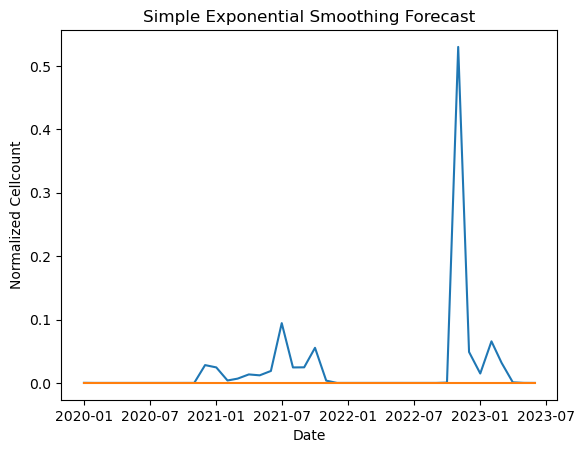

In [21]:
fitab2 = SimpleExpSmoothing(trainab2.CELLCOUNT.values).fit(smoothing_level=0.0, optimized=False)
predictionab2 = fitab2.forecast(len(testab2))

plt.plot(testab2.index, testab2.CELLCOUNT)
plt.plot(testab2.index, predictionab2)
plt.xlabel("Date")
plt.ylabel("Normalized Cellcount")
plt.title("Simple Exponential Smoothing Forecast")

In [22]:
mse(testab2.CELLCOUNT, predictionab2, squared=False)

0.08511252170691645

#### ab3 : Rolling Average

In [23]:
len(trainab3.roll_avg)

75825

In [24]:
alpha = np.arange(0,1.05,0.05)
splitstrain = 12
splitstest = 5055 #3/15 of the whole same as for ab2

In [25]:
rmses = np.zeros((len(alpha), splitstrain))
cv = TimeSeriesSplit(splitstrain, test_size=splitstest)
c = 0
scale = 1
for train_index, test_index in cv.split(trainab3):
    tv_tt = trainab3.iloc[train_index]
    tv_ho = trainab3.iloc[test_index]
    print(test_index) #making sure the splits are working
    for i, j in enumerate(alpha):
        fit = SimpleExpSmoothing(tv_tt.roll_avg.values/scale).fit(smoothing_level=j, optimized=False)
        prediction = fit.forecast(len(tv_ho))
        rmses[i,c] = mse(tv_ho.roll_avg.values/scale, prediction, squared=False)

        plt.figure(figsize=(10,8))
        plt.plot(tv_ho.index, tv_ho.roll_avg/scale, 'b',label="Test Data")
        plt.plot(tv_ho.index, prediction, 'r',label="Forecast")
        plt.xlabel("Date")
        plt.ylabel("Cell Count")
        plt.title(f"Alpha {j} Column {c} Simple Exp Smoothing Forecast of Per Month Data")
        plt.legend()
        plt.savefig(f"ab3_simpleExpSmoothing/Alpha_{j}_Column_{c}_Simple_Exp_Smoothing_Forecast_of_Per_Month_Data.png")
        plt.close()

    
    c += 1

[15165 15166 15167 ... 20217 20218 20219]
[20220 20221 20222 ... 25272 25273 25274]
[25275 25276 25277 ... 30327 30328 30329]
[30330 30331 30332 ... 35382 35383 35384]
[35385 35386 35387 ... 40437 40438 40439]
[40440 40441 40442 ... 45492 45493 45494]
[45495 45496 45497 ... 50547 50548 50549]
[50550 50551 50552 ... 55602 55603 55604]
[55605 55606 55607 ... 60657 60658 60659]
[60660 60661 60662 ... 65712 65713 65714]
[65715 65716 65717 ... 70767 70768 70769]
[70770 70771 70772 ... 75822 75823 75824]


In [26]:
sesrms = np.zeros(len(alpha))
for i,j in enumerate(alpha):
    avg_rms = rmses[i,:].mean()
    sesrms[i] = avg_rms
    k = "{:e}".format(avg_rms)
    print(f"Room Mean Square for Alpha {j} is {k}")

best = "{:e}".format(sesrms.min())
print(f"Best RMS is {best}")

Room Mean Square for Alpha 0.0 is 5.496211e-02
Room Mean Square for Alpha 0.05 is 5.350859e-02
Room Mean Square for Alpha 0.1 is 5.352951e-02
Room Mean Square for Alpha 0.15000000000000002 is 5.352846e-02
Room Mean Square for Alpha 0.2 is 5.352856e-02
Room Mean Square for Alpha 0.25 is 5.352911e-02
Room Mean Square for Alpha 0.30000000000000004 is 5.352982e-02
Room Mean Square for Alpha 0.35000000000000003 is 5.353058e-02
Room Mean Square for Alpha 0.4 is 5.353137e-02
Room Mean Square for Alpha 0.45 is 5.353218e-02
Room Mean Square for Alpha 0.5 is 5.353302e-02
Room Mean Square for Alpha 0.55 is 5.353389e-02
Room Mean Square for Alpha 0.6000000000000001 is 5.353481e-02
Room Mean Square for Alpha 0.65 is 5.353578e-02
Room Mean Square for Alpha 0.7000000000000001 is 5.353680e-02
Room Mean Square for Alpha 0.75 is 5.353789e-02
Room Mean Square for Alpha 0.8 is 5.353903e-02
Room Mean Square for Alpha 0.8500000000000001 is 5.354022e-02
Room Mean Square for Alpha 0.9 is 5.354147e-02
Room Mea

## <span style=color:red> Best Result was Alpha = 0.05 at RMS 9.332373e+05 </span>

Text(0.5, 1.0, 'Simple Exponential Smoothing Forecast')

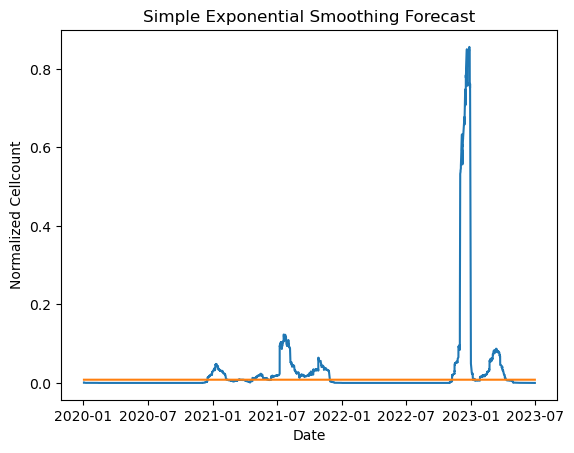

In [27]:
fitab3 = SimpleExpSmoothing(trainab3.roll_avg.values).fit(smoothing_level=0.05, optimized=False)
predictionab3 = fitab3.forecast(len(testab3))

plt.plot(testab3.index, testab3.roll_avg)
plt.plot(testab3.index, predictionab3)
plt.xlabel("Date")
plt.ylabel("Normalized Cellcount")
plt.title("Simple Exponential Smoothing Forecast")

In [28]:
mse(testab3.CELLCOUNT, predictionab3, squared=False)

0.011732990082540341

### ARIMA

#### ab2 : Average Per Month

In [10]:
#p number of previous observations used in the model
#d number of times it undergoes differencing
#q moving average window

In [29]:
import pmdarima as pm

In [30]:
parfind = pm.auto_arima(trainab2['CELLCOUNT'], start_p=1, d=1,
                       start_q=1, trace=True, error_action='ignore',
                        seasonal=False, stepwise=True)

parfind.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1560.523, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1234.402, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1388.081, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1562.255, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1236.402, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1560.538, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1566.673, Time=0.69 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1566.655, Time=0.90 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1566.224, Time=0.96 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1559.121, Time=0.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1558.823, Time=0.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1585.154, Time=1.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1589.369, Time=1.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1569.873, Time=1.17 sec
 ARIMA(4,1,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  612
Model:               SARIMAX(2, 1, 4)   Log Likelihood                 804.401
Date:                Fri, 26 Apr 2024   AIC                          -1594.803
Time:                        18:10:41   BIC                          -1563.897
Sample:                             0   HQIC                         -1582.782
                                - 612                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2231      0.047    -26.040      0.000      -1.315      -1.131
ar.L2         -0.8482      0.039    -21.773      0.000      -0.925      -0.772
ma.L1          0.4306      0.054      8.024      0.000       0.325       0.536
ma.L2         -0.1777      0.043     -4.112      0.000      -0.262      -0.093
ma.L3         -0.7011      0.043    -16.369      0.000      -0.785      -0.617
ma.L4         -0.1904      0.032     -5.869      0.000      -0.254      -0.127
sigma2         0.0042   7.11e-05     58.996      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             81514.40
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             5.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# at seasonal = False the best model was (2,1,4)

In [31]:
trainarima2 = trainab2.copy()

In [32]:
trainarima2.index = trainarima2.index.to_period('M')

In [33]:
sarimaab2 = sm.ARIMA(trainarima2['CELLCOUNT'], order=(2,1,4))
fitarimaab2 = sarimaab2.fit() 

In [34]:
fitarimaab2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CELLCOUNT   No. Observations:                  612
Model:                 ARIMA(2, 1, 4)   Log Likelihood                 804.401
Date:                Fri, 26 Apr 2024   AIC                          -1594.803
Time:                        18:11:04   BIC                          -1563.897
Sample:                    02-28-1954   HQIC                         -1582.782
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2231      0.047    -26.040      0.000      -1.315      -1.131
ar.L2         -0.8482      0.039    -21.773      0.000      -0.925      -0.772
ma.L1          0.4306      0.054      8.024      0.000       0.325       0.536
ma.L2         -0.1777      0.043     -4.112      0.000      -0.262      -0.093
ma.L3         -0.7011      0.043    -16.369      0.000      -0.785      -0.617
ma.L4         -0.1904      0.032     -5.869      0.000      -0.254      -0.127
sigma2         0.0042   7.11e-05     58.996      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             81514.40
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             5.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
arimapredictab2 = fitarimaab2.forecast(len(testab2))
#arimapredictab2 = fitarimaab2.get_forecast(steps=len(testab2))

In [35]:
#arimapredictab2

In [37]:
mse(testab2.CELLCOUNT, arimapredictab2, squared=False)

0.08349426702521481

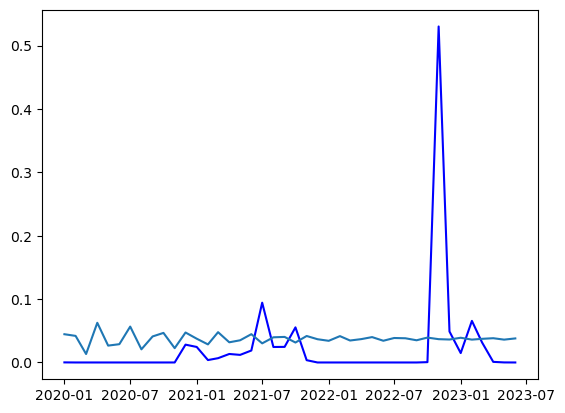

In [38]:
plt.plot(testab2.index, testab2.CELLCOUNT,'b',label='Test')
plt.plot(testab2.index, arimapredictab2)

## ab3

In [39]:
parfind = pm.auto_arima(trainab3['roll_avg'], start_p=1, d=1,
                       start_q=1, trace=True, error_action='ignore',
                        seasonal=False, stepwise=True)

parfind.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-546134.452, Time=25.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-546118.877, Time=12.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-546146.072, Time=9.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-546147.713, Time=11.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-546120.877, Time=4.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-546197.396, Time=13.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-546193.933, Time=18.78 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-546198.178, Time=18.62 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-546191.020, Time=34.89 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-546234.232, Time=11.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-546252.074, Time=33.67 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-546282.056, Time=29.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-546166.186, Time=48.67 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-546309

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                75825
Model:               SARIMAX(2, 1, 5)   Log Likelihood              273165.265
Date:                Fri, 26 Apr 2024   AIC                        -546314.531
Time:                        18:22:33   BIC                        -546240.641
Sample:                             0   HQIC                       -546291.824
                              - 75825                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0752      0.077      0.973      0.330      -0.076       0.227
ar.L2          0.6129      0.056     10.977      0.000       0.503       0.722
ma.L1         -0.0963      0.077     -1.247      0.213      -0.248       0.055
ma.L2         -0.6385      0.057    -11.124      0.000      -0.751      -0.526
ma.L3          0.0071      0.001      5.821      0.000       0.005       0.010
ma.L4          0.0383      0.001     42.129      0.000       0.036       0.040
ma.L5          0.0136      0.003      5.324      0.000       0.009       0.019
sigma2      4.348e-05   4.53e-09   9602.654      0.000    4.35e-05    4.35e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):       80094018492.38
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            27.47
Prob(H) (two-sided):                  0.00   Kurtosis:                      5037.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.06e+14. Standard errors may be unstable.
"""

In [ ]:
# best arima parameters 2,1,5

In [40]:
trainarima3 = trainab3.copy()
trainarima3.index = trainarima3.index.to_period('M')

In [41]:
sarimaab3 = sm.ARIMA(trainarima3['roll_avg'], order=(2,1,5))
fitarimaab3 = sarimaab3.fit() 

In [42]:
arimapredictab3 = fitarimaab3.forecast(len(testab3))

In [43]:
mse(testab3.CELLCOUNT, arimapredictab3, squared=False)

0.008800336860366737

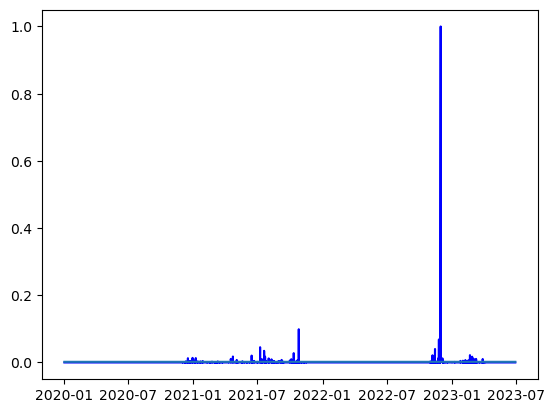

In [44]:
plt.plot(testab3.index, testab3.CELLCOUNT,'b',label='Test')
plt.plot(testab3.index, arimapredictab3)

### Random Forest Model

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [86]:
model2 = RandomForestRegressor()

In [87]:
trainab2.columns
treeab2 = trainab2.copy()
treeab2test = testab2.copy()

In [88]:
treeab2.reset_index(inplace=True)
treeab2test.reset_index(inplace=True)

In [89]:
treeab2['day'] = treeab2['index'].dt.day.astype(int)
treeab2['month'] = treeab2['index'].dt.month.astype(int)
treeab2['year'] = treeab2['index'].dt.year.astype(int)

In [90]:
treeab2test['day'] = treeab2test['index'].dt.day.astype(int)
treeab2test['month'] = treeab2test['index'].dt.month.astype(int)
treeab2test['year'] = treeab2test['index'].dt.year.astype(int)

In [91]:
#Normalize the data
#(x - min) / (max - min)

#treeab2['CELLCOUNT'] = (treeab2['CELLCOUNT'] - treeab2['CELLCOUNT'].min()) / (treeab2['CELLCOUNT'].max() - treeab2['CELLCOUNT'].min())
#treeab2['SALINITY'] = (treeab2['SALINITY']- treeab2['SALINITY'].min()) / (treeab2['SALINITY'].max() - treeab2['SALINITY'].min())
#treeab2['WATER_TEMP'] = (treeab2['WATER_TEMP']- treeab2['WATER_TEMP'].min()) / (treeab2['WATER_TEMP'].max() - treeab2['WATER_TEMP'].min())

In [92]:
#treeab2test['CELLCOUNT'] = (treeab2test['CELLCOUNT'] - treeab2test['CELLCOUNT'].min()) / (treeab2test['CELLCOUNT'].max() - treeab2test['CELLCOUNT'].min())
#treeab2test['SALINITY'] = (treeab2test['SALINITY']- treeab2test['SALINITY'].min()) / (treeab2test['SALINITY'].max() - treeab2test['SALINITY'].min())
#treeab2test['WATER_TEMP'] = (treeab2test['WATER_TEMP']- treeab2test['WATER_TEMP'].min()) / (treeab2test['WATER_TEMP'].max() - treeab2test['WATER_TEMP'].min())

In [93]:
target = treeab2['CELLCOUNT']
features = treeab2[['SALINITY', 'WATER_TEMP','day','month','year']]

In [94]:
model2.fit(features, target)

RandomForestRegressor()

In [95]:
predictiontreeab2 = model2.predict(treeab2test[['SALINITY', 'WATER_TEMP','day','month','year']])

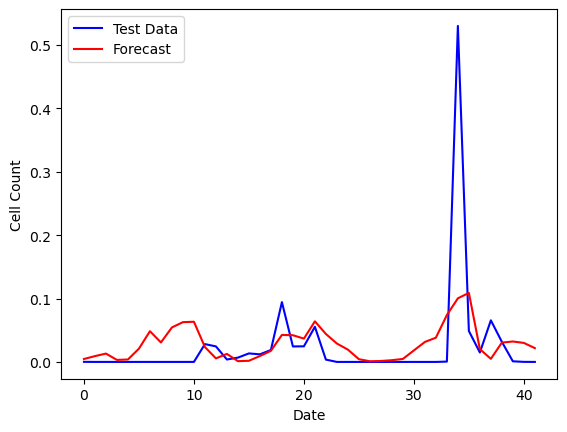

In [96]:
plt.plot(treeab2test.index,treeab2test.CELLCOUNT/scale,'b',label='Test Data')
plt.plot(treeab2test.index, predictiontreeab2,'r',label='Forecast')
plt.xlabel('Date')
plt.ylabel('Cell Count')
plt.legend()
plt.show()
plt.close()

In [97]:
print('Root Mean Square is ', "{:e}".format(mse(treeab2test.CELLCOUNT, predictiontreeab2, squared=False)))

Root Mean Square is  7.306968e-02


In [98]:
model3 = RandomForestRegressor()

In [99]:
treeab3 = trainab3.copy()
treeab3test = testab3.copy()

In [100]:
treeab3.reset_index(inplace=True)
treeab3test.reset_index(inplace=True)

#treeab3.head()

In [101]:
treeab3['day'] = treeab3['SAMPLE_DATE'].dt.day.astype(int)
treeab3['month'] = treeab3['SAMPLE_DATE'].dt.month.astype(int)
treeab3['year'] = treeab3['SAMPLE_DATE'].dt.year.astype(int)

In [102]:
treeab3test['day'] = treeab3test['SAMPLE_DATE'].dt.day.astype(int)
treeab3test['month'] = treeab3test['SAMPLE_DATE'].dt.month.astype(int)
treeab3test['year'] = treeab3test['SAMPLE_DATE'].dt.year.astype(int)

In [103]:
#Normalize the data
#(x - min) / (max - min)

#treeab3['CELLCOUNT'] = (treeab3['CELLCOUNT'] - treeab3['CELLCOUNT'].min()) / (treeab3['CELLCOUNT'].max() - treeab3['CELLCOUNT'].min())
#treeab3['SALINITY'] = (treeab3['SALINITY']- treeab3['SALINITY'].min()) / (treeab3['SALINITY'].max() - treeab3['SALINITY'].min())
#treeab3['WATER_TEMP'] = (treeab3['WATER_TEMP']- treeab3['WATER_TEMP'].min()) / (treeab3['WATER_TEMP'].max() - treeab3['WATER_TEMP'].min())

#treeab3test['CELLCOUNT'] = (treeab3test['CELLCOUNT'] - treeab3test['CELLCOUNT'].min()) / (treeab3test['CELLCOUNT'].max() - treeab3test['CELLCOUNT'].min())
#treeab3test['SALINITY'] = (treeab3test['SALINITY']- treeab3test['SALINITY'].min()) / (treeab3test['SALINITY'].max() - treeab3test['SALINITY'].min())
#treeab3test['WATER_TEMP'] = (treeab3test['WATER_TEMP']- treeab3test['WATER_TEMP'].min()) / (treeab3test['WATER_TEMP'].max() - treeab3test['WATER_TEMP'].min())

In [104]:
target = treeab3['roll_avg']
features = treeab3[['SALINITY', 'WATER_TEMP', 'day','month','year']]

In [105]:
#THERES NA IN sample depth so I'm just not using that column for now

In [106]:
model3.fit(features, target)

RandomForestRegressor()

In [107]:
predictiontreeab3 = model3.predict(treeab3test[['SALINITY', 'WATER_TEMP','day','month','year']])

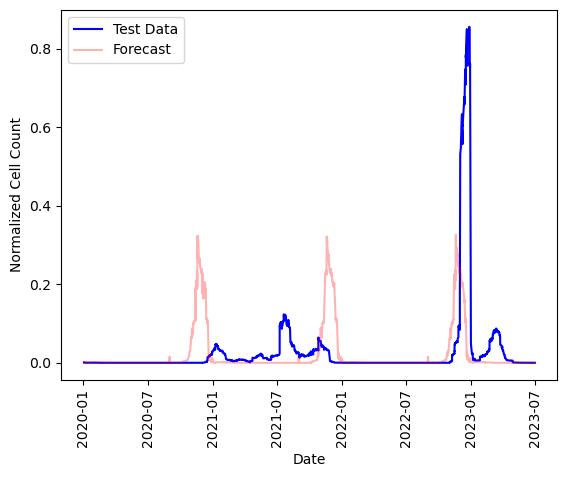

In [108]:
plt.plot(treeab3test['SAMPLE_DATE'],treeab3test.roll_avg,'b',label='Test Data')
plt.plot(treeab3test['SAMPLE_DATE'], predictiontreeab3,'r',label='Forecast',alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Normalized Cell Count')
plt.xticks(rotation=90)
plt.legend()
plt.show()
plt.close()

In [109]:
print('Root Mean Square is ', "{:e}".format(mse(treeab3test.roll_avg, predictiontreeab3, squared=False)))

Root Mean Square is  9.019981e-02


| Models                              | Monthly Average |  Raw Data   |  Rolling Aveage (30 days) |
| :---------------- | :------: | :------: | ----: |
| Simple Exponential Smoothing        |   8.46e-02   | 8.61e-03 |  1.17e-02    |
| ARIMA                               |   8.34E-02   | tba |  8.80e-03   |
| Random Forest                       |  7.44e-02   | 8.77e-03 |  9.01e-02   |
   

| Models                              | Root Mean Square|
| :---------------- | ------: | 
|Average Baseline |  8.183e-02   |
| Simple Exponential Smoothing        |  1.17e-02   |
| ARIMA                               |  8.80e-03   |
| Random Forest                       |  9.01e-02   |
   

## Lets predict the Future

In [82]:
#Generating Future data
#The next year
futvarab2 = treeab2test.groupby(treeab2test['index'].dt.month)[['SALINITY','WATER_TEMP']].mean()


In [83]:
futvarab2['date'] = [datetime(2024,i,1) for i in futvarab2.index]

In [84]:
futvarab2['day'] = futvarab2['date'].dt.day.astype(int)
futvarab2['month'] = futvarab2['date'].dt.month.astype(int)
futvarab2['year'] = futvarab2['date'].dt.year.astype(int)

In [120]:
futvarab3 = treeab3test.groupby(treeab3test['SAMPLE_DATE'].dt.month)[['SALINITY','WATER_TEMP']].mean()


In [121]:
futvarab3.reset_index()
futvarab3['SAMPLE_DATE'] = [datetime(2024,i,1) for i in futvarab3.index]
                            
futvarab3['day'] = futvarab3['SAMPLE_DATE'].dt.day.astype(int)
futvarab3['month'] = futvarab3['SAMPLE_DATE'].dt.month.astype(int)
futvarab3['year'] = futvarab3['SAMPLE_DATE'].dt.year.astype(int)                           

### Random Forest ab2

In [113]:
futtreeab2 = model2.predict(futvarab2[['SALINITY', 'WATER_TEMP','day','month','year']])

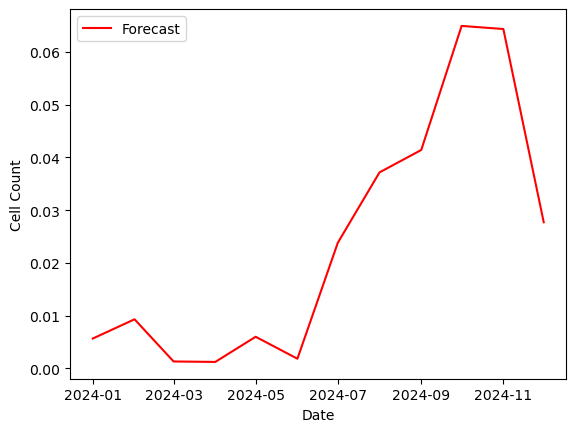

In [114]:
plt.plot(futvarab2.date, futtreeab2,'r',label='Forecast')
plt.xlabel('Date')
plt.ylabel('Cell Count')
plt.legend()
plt.show()
plt.close()

## Random Forest ab3

In [122]:
futtreeab3 = model3.predict(futvarab3[['SALINITY', 'WATER_TEMP','day','month','year']])

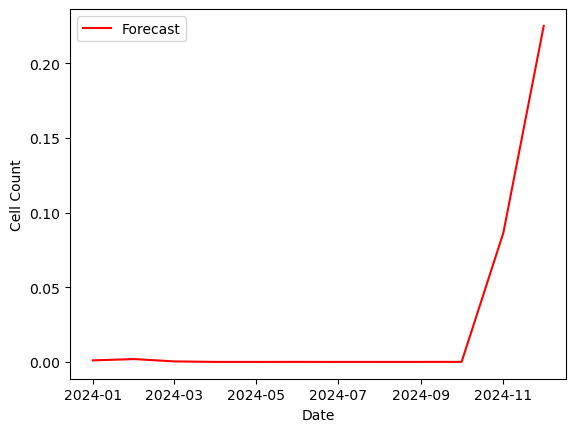

In [123]:
plt.plot(futvarab3.SAMPLE_DATE, futtreeab3,'r',label='Forecast')
plt.xlabel('Date')
plt.ylabel('Cell Count')
plt.legend()
plt.show()
plt.close()

## ARIMA ab2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


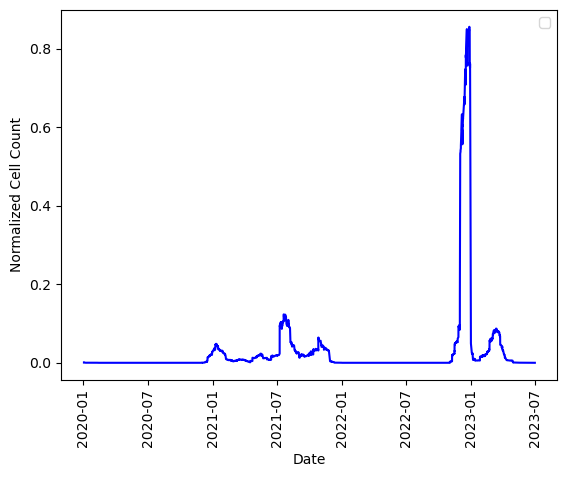

In [45]:
plt.plot(treeab3test['SAMPLE_DATE'],treeab3test.roll_avg,'b')
plt.xlabel('Date')
plt.ylabel('Normalized Cell Count')
plt.xticks(rotation=90)
plt.legend()
plt.show()
plt.savefig
plt.close()

In [57]:
aaa = trainab2['CELLCOUNT'].mean()

In [58]:
avgpred = aaa*np.ones(len(testab2))
avgpred

array([0.01913722, 0.01913722, 0.01913722, 0.01913722, 0.01913722,
       0.01913722, 0.01913722, 0.01913722, 0.01913722, 0.01913722,
       0.01913722, 0.01913722, 0.01913722, 0.01913722, 0.01913722,
       0.01913722, 0.01913722, 0.01913722, 0.01913722, 0.01913722,
       0.01913722, 0.01913722, 0.01913722, 0.01913722, 0.01913722,
       0.01913722, 0.01913722, 0.01913722, 0.01913722, 0.01913722,
       0.01913722, 0.01913722, 0.01913722, 0.01913722, 0.01913722,
       0.01913722, 0.01913722, 0.01913722, 0.01913722, 0.01913722,
       0.01913722, 0.01913722])

In [59]:
mse(testab2.CELLCOUNT, avgpred, squared=False)

0.08183251009390509

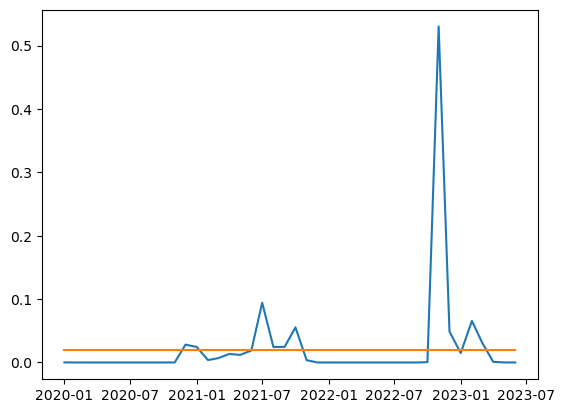

In [60]:
plt.plot(testab2.index, testab2.CELLCOUNT)
plt.plot(testab2.index, avgpred)
plt.show()